In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import AdamW, LBFGS
from torch import GradScaler
from scipy.linalg import expm
from scipy.optimize import minimize

In [2]:
# One-qubit operators
sigma_x = torch.tensor([[0., 1.], [1., 0.]], dtype=torch.complex64)
sigma_y = torch.tensor([[0., -1j], [1j, 0.]], dtype=torch.complex64)
sigma_z = torch.tensor([[1., 0.], [0., -1.]], dtype=torch.complex64)
identity = torch.eye(2, dtype=torch.complex64)
# Two-qubit operators
# Qubit 1 controls
sx1 = torch.kron(sigma_x, identity)  # σₓ ⊗ I
sz1 = torch.kron(sigma_z, identity)  # σ_z ⊗ I
# Qubit 2 controls
sx2 = torch.kron(identity, sigma_x)  # I ⊗ σₓ
sz2 = torch.kron(identity, sigma_z)  # I ⊗ σ_z
# Coupling
szx = torch.kron(sigma_z, sigma_x)  # σ_z ⊗ σ_z

In [3]:
H_target = (1/np.sqrt(2)) * torch.tensor([[1., 1.], [1., -1.]], dtype=torch.complex64)
T_target = torch.tensor([[1., 0.], [0., np.exp(1j * np.pi / 4)]], dtype=torch.complex64)
CNOT_target = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=torch.complex64)

In [4]:
# System parameters
T_total = 1.0    # total time
N = 32           # number of time steps
dt = T_total / N # delta time
time_grid = torch.linspace(0, T_total, N)
K = 5
freqs = torch.linspace(1.0, 5.0, K)
omega0 = 2 * np.pi / T_total

In [5]:
# GRAPE
def propagate_grape(params, target):
  if target.shape[0] == 2:
    u_x = params['ux']
    u_z = params['uz']
    U = torch.eye(2, dtype=torch.complex64)
    for n in range(N):
      H = u_x[n] * sigma_x + u_z[n] * sigma_z
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  else:
    u1x = params['u1x']
    u1z = params['u1z']
    u2x = params['u2x']
    u2z = params['u2z']
    jzx = params['jzx']
    U = torch.eye(4, dtype=torch.complex64)
    for n in range(N):
      H = jzx[n] * szx + u1x[n] * sx1 + u1z[n] * sz1 + u2x[n] * sx2 + u2z[n] * sz2
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  return U

def process_fidelity_grape(U, U_target):
    dim = U_target.shape[0]
    fidelity = torch.clamp((torch.abs(torch.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = torch.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def loss_fn_grape(U, U_target):
    # Compute the global phase factor from the trace overlap
    trace_val = torch.trace(U_target.conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = torch.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = torch.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = U_target - U_aligned
    loss = torch.norm(diff, p='fro')**2
    return loss

def train_grape(iters, optimizer, params, target):
  scaler = GradScaler('cpu')
  loss_list, fid_list, inf_list = [], [], []
  for it in range(iters):
    optimizer.zero_grad(set_to_none=True)
    U = propagate_grape(params, target)
    loss = loss_fn_grape(U, target)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    fid, inf = process_fidelity_grape(U, target)
    loss_list.append(loss.item())
    fid_list.append(fid)
    inf_list.append(inf)
    if it % 100 == 0 or it == num_iters-1:
        print(f"Iteration {it}: Loss = {loss.item()}")
        print(f"Fidelity = {fid}, Infidelity = {inf}")
  return loss_list, fid_list, inf_list

In [6]:
# CRAB
def process_fidelity_crab(U, U_target):
    dim = U_target.shape[0]
    fidelity = np.clip((np.abs(np.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = np.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def drive_control(t, x):
    # x[0:K]: alpha coefficients, x[K:2K]: beta coefficients.
    alphas = x[:K]
    betas = x[K:2*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += alphas[k-1] * np.cos(k * omega0 * t) + betas[k-1] * np.sin(k * omega0 * t)
    return pulse

def detuning_control(t, x):
    # x[2K:3K]: gamma coefficients, x[3K:4K]: delta coefficients.
    gammas = x[2*K:3*K]
    deltas = x[3*K:4*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += gammas[k-1] * np.cos(k * omega0 * t) + deltas[k-1] * np.sin(k * omega0 * t)
    return pulse

# Total control pulse applied in the Hamiltonian.
# H(t) = εₓ(t) σ_x + ε_z(t) σ_z.
def hamiltonian(t, x):
    eps_x = drive_control(t, x)
    eps_z = detuning_control(t, x)
    return eps_x * sigma_x + eps_z * sigma_z

def propagate_crab(x):
  U = np.eye(2).copy()
  for t in time_grid:
    H = hamiltonian(t, x)
    U_step = expm(-1j * H * dt)
    U = U_step @ U
  return U

In [7]:
ux_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_adam, 'uz': uz_grape_h_adam}
optimizer = AdamW([ux_grape_h_adam, uz_grape_h_adam], lr=0.001, weight_decay=0.001)

In [8]:
num_iters = 3000
loss_list_grape_h_adam, fid_list_grape_h_adam, inf_list_grape_h_adam = train_grape(num_iters, optimizer, params, H_target)

Iteration 0: Loss = 3.3701398372650146
Fidelity = 0.024795163422822952, Infidelity = -0.010904158465564251
Iteration 100: Loss = 2.833273410797119
Fidelity = 0.08507821708917618, Infidelity = -0.03861604258418083
Iteration 200: Loss = 2.330181360244751
Fidelity = 0.17426832020282745, Infidelity = -0.08316104859113693
Iteration 300: Loss = 1.8741422891616821
Fidelity = 0.28245440125465393, Infidelity = -0.1441504806280136
Iteration 400: Loss = 1.47393000125885
Fidelity = 0.39881432056427, Infidelity = -0.2209913730621338
Iteration 500: Loss = 1.1337028741836548
Fidelity = 0.5134785771369934, Infidelity = -0.31289803981781006
Iteration 600: Loss = 0.8533358573913574
Fidelity = 0.6188432574272156, Infidelity = -0.4188964068889618
Iteration 700: Loss = 0.6292130947113037
Fidelity = 0.7101372480392456, Infidelity = -0.5378075838088989
Iteration 800: Loss = 0.45525333285331726
Fidelity = 0.7853267192840576, Infidelity = -0.6682220101356506
Iteration 900: Loss = 0.3239901065826416
Fidelity = 

In [9]:
ux_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_lbfgs, 'uz': uz_grape_h_lbfgs}

loss_list_grape_h_lbfgs, fid_list_grape_h_lbfgs, inf_list_grape_h_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, H_target)
  loss = loss_fn_grape(U, H_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, H_target)
  loss_list_grape_h_lbfgs.append(loss.item())
  fid_list_grape_h_lbfgs.append(fid)
  inf_list_grape_h_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_h_lbfgs , uz_grape_h_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_h_lbfgs[-1]}, Infidelity: {inf_list_grape_h_lbfgs[-1]}")

Iteration 0, Loss: 3.370490074157715
Fidelity: 0.04740510135889053, Infidelity: -0.021091759204864502
Iteration 10, Loss: 0.9778513312339783
Fidelity: 0.5953708291053772, Infidelity: -0.3929428160190582
Iteration 20, Loss: 0.42844057083129883
Fidelity: 0.811311662197113, Infidelity: -0.7242549657821655
Iteration 30, Loss: 0.20315240323543549
Fidelity: 0.9086057543754578, Infidelity: -1.03908109664917
Iteration 40, Loss: 0.09418288618326187
Fidelity: 0.9566618800163269, Infidelity: -1.36312997341156
Iteration 50, Loss: 0.04111684486269951
Fidelity: 0.980697751045227, Infidelity: -1.714392066001892
Iteration 60, Loss: 0.014808537438511848
Fidelity: 0.9933337569236755, Infidelity: -2.176118850708008
Iteration 70, Loss: 0.004956683609634638
Fidelity: 0.9977198839187622, Infidelity: -2.642043113708496
Iteration 80, Loss: 0.0019624168053269386
Fidelity: 0.9990984797477722, Infidelity: -3.0450243949890137
Iteration 90, Loss: 0.0007643823628313839
Fidelity: 0.9996508955955505, Infidelity: -3.4

In [10]:
loss_list_crab_h, fid_list_crab_h, inf_list_crab_h = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(H_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = H_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_h.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, H_target.numpy())
    fid_list_crab_h.append(fid)
    inf_list_crab_h.append(inf)
    return loss

In [11]:
x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_17073/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 821
         Function evaluations: 1222


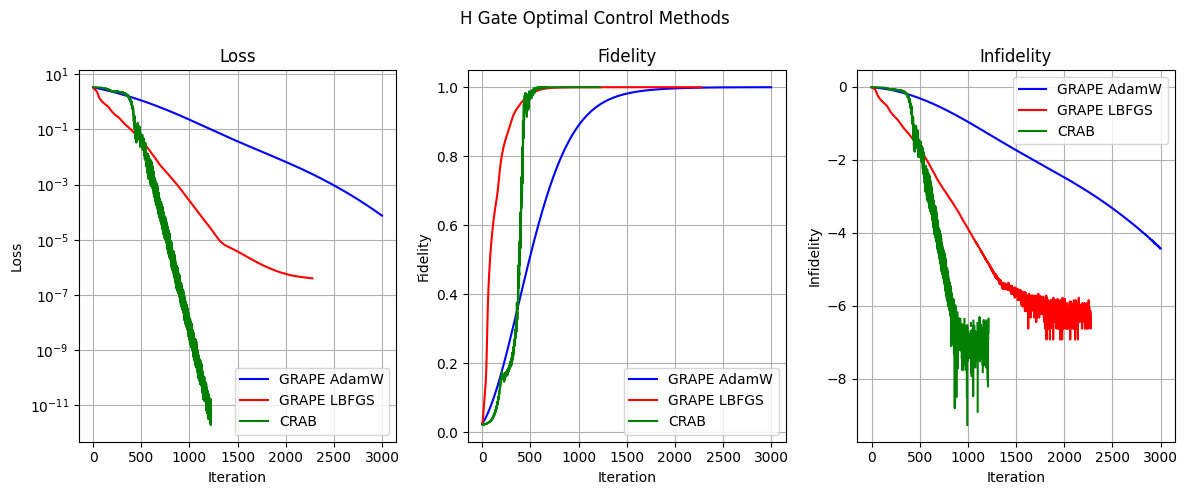

In [12]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle("H Gate Optimal Control Methods")
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_h, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_h, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_h, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Methods.png"
)
plt.tight_layout()
plt.show()

In [13]:
pd.DataFrame({'loss_grape_h_adam': loss_list_grape_h_adam, 'fid_grape_h_adam': fid_list_grape_h_adam, 'inf_grape_h_adam': inf_list_grape_h_adam}).to_csv('grape_h_adam.csv')
pd.DataFrame({'loss_grape_h_lbfgs': loss_list_grape_h_lbfgs, 'fid_grape_h_lbfgs': fid_list_grape_h_lbfgs, 'inf_grape_h_lbfgs': inf_list_grape_h_lbfgs}).to_csv('grape_h_lbfgs.csv')
pd.DataFrame({'loss_crab_h': loss_list_crab_h, 'fid_crab_h': fid_list_crab_h, 'inf_crab_h': inf_list_crab_h}).to_csv('crab_h.csv')

In [14]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_h_adam = ux_grape_h_adam.detach().cpu().numpy()
uz_grape_h_adam = uz_grape_h_adam.detach().cpu().numpy()
ux_grape_h_lbfgs = ux_grape_h_lbfgs.detach().cpu().numpy()
uz_grape_h_lbfgs = uz_grape_h_lbfgs.detach().cpu().numpy()

x_opt = res.x
ux_grape_h_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_h_crab = [detuning_control(t, x_opt) for t in time_grid]

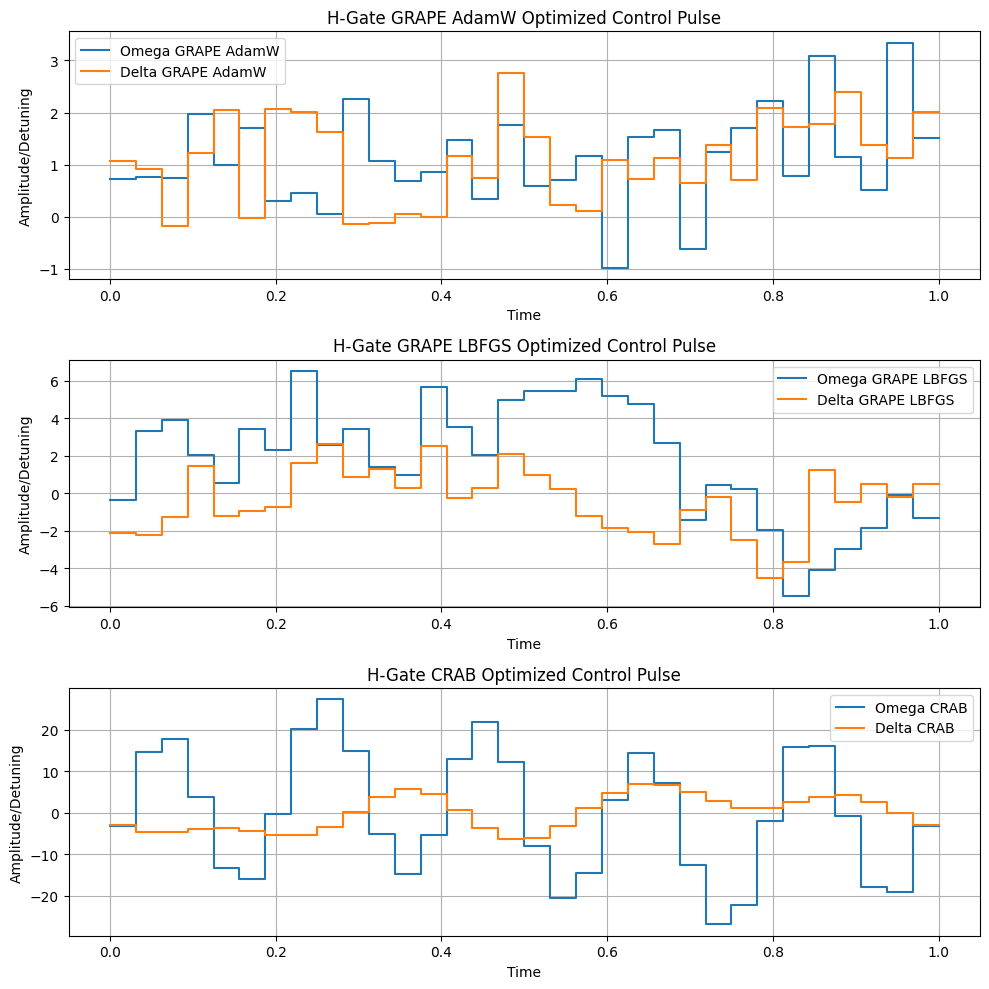

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.step(time_edges, np.append(ux_grape_h_adam, ux_grape_h_adam[-1]), where='post', label='Omega GRAPE AdamW')
plt.step(time_edges, np.append(uz_grape_h_adam, uz_grape_h_adam[-1]), where='post', label='Delta GRAPE AdamW')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.step(time_edges, np.append(ux_grape_h_lbfgs, ux_grape_h_lbfgs[-1]), where='post', label='Omega GRAPE LBFGS')
plt.step(time_edges, np.append(uz_grape_h_lbfgs, uz_grape_h_lbfgs[-1]), where='post', label='Delta GRAPE LBFGS')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)
plt.step(time_edges, np.append(ux_grape_h_crab, ux_grape_h_crab[-1]), where='post', label='Omega CRAB')
plt.step(time_edges, np.append(uz_grape_h_crab, uz_grape_h_crab[-1]), where='post', label='Delta CRAB')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Pulses.png"
)
plt.show()

In [16]:
# T-Gate
ux_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_adam, 'uz': uz_grape_t_adam}
optimizer = AdamW([ux_grape_t_adam, uz_grape_t_adam], lr=0.001, weight_decay=0.001)

In [17]:
num_iters = 1200
loss_list_grape_t_adam, fid_list_grape_t_adam, inf_list_grape_t_adam = train_grape(num_iters, optimizer, params, T_target)

Iteration 0: Loss = 0.8548762202262878
Fidelity = 0.6182376742362976, Infidelity = -0.41820693016052246
Iteration 100: Loss = 0.6283124089241028
Fidelity = 0.710517942905426, Infidelity = -0.5383783578872681
Iteration 200: Loss = 0.4466172754764557
Fidelity = 0.7891583442687988, Infidelity = -0.6760435700416565
Iteration 300: Loss = 0.30448153614997864
Fidelity = 0.8535536527633667, Infidelity = -0.8343214392662048
Iteration 400: Loss = 0.19820314645767212
Fidelity = 0.9033533930778503, Infidelity = -1.0148134231567383
Iteration 500: Loss = 0.12457629293203354
Fidelity = 0.9386810660362244, Infidelity = -1.2124054431915283
Iteration 600: Loss = 0.07642298936843872
Fidelity = 0.9621531963348389, Infidelity = -1.4219708442687988
Iteration 700: Loss = 0.045775193721055984
Fidelity = 0.9772425293922424, Infidelity = -1.6428760290145874
Iteration 800: Loss = 0.026482801884412766
Fidelity = 0.9868022799491882, Infidelity = -1.8795011043548584
Iteration 900: Loss = 0.014630821533501148
Fideli

In [18]:
ux_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_lbfgs, 'uz': uz_grape_t_lbfgs}

loss_list_grape_t_lbfgs, fid_list_grape_t_lbfgs, inf_list_grape_t_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, T_target)
  loss = loss_fn_grape(U, T_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, T_target)
  loss_list_grape_t_lbfgs.append(loss.item())
  fid_list_grape_t_lbfgs.append(fid)
  inf_list_grape_t_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_t_lbfgs , uz_grape_t_lbfgs], lr=0.001, max_iter=10)

num_iterations = 120
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_t_lbfgs[-1]}, Infidelity: {inf_list_grape_t_lbfgs[-1]}")

Iteration 0, Loss: 0.24305328726768494
Fidelity: 0.8840506076812744, Infidelity: -0.9357315301895142
Iteration 10, Loss: 0.1973859667778015
Fidelity: 0.9055430293083191, Infidelity: -1.024765968322754
Iteration 20, Loss: 0.15763573348522186
Fidelity: 0.9243729114532471, Infidelity: -1.1213226318359375
Iteration 30, Loss: 0.12211331725120544
Fidelity: 0.9413605332374573, Infidelity: -1.2318099737167358
Iteration 40, Loss: 0.06260150671005249
Fidelity: 0.9715363383293152, Infidelity: -1.545709252357483
Iteration 50, Loss: 0.028270656242966652
Fidelity: 0.9870766997337341, Infidelity: -1.8886265754699707
Iteration 60, Loss: 0.013477222062647343
Fidelity: 0.9936405420303345, Infidelity: -2.196579933166504
Iteration 70, Loss: 0.00637577660381794
Fidelity: 0.99699866771698, Infidelity: -2.522686004638672
Iteration 80, Loss: 0.003124215640127659
Fidelity: 0.9985305666923523, Infidelity: -2.832850217819214
Iteration 90, Loss: 0.0016050264239311218
Fidelity: 0.9992550611495972, Infidelity: -3.1

In [19]:
loss_list_crab_t, fid_list_crab_t, inf_list_crab_t = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(T_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = T_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_t.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, T_target.numpy())
    fid_list_crab_t.append(fid)
    inf_list_crab_t.append(inf)
    return loss

x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_17073/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 732
         Function evaluations: 1071


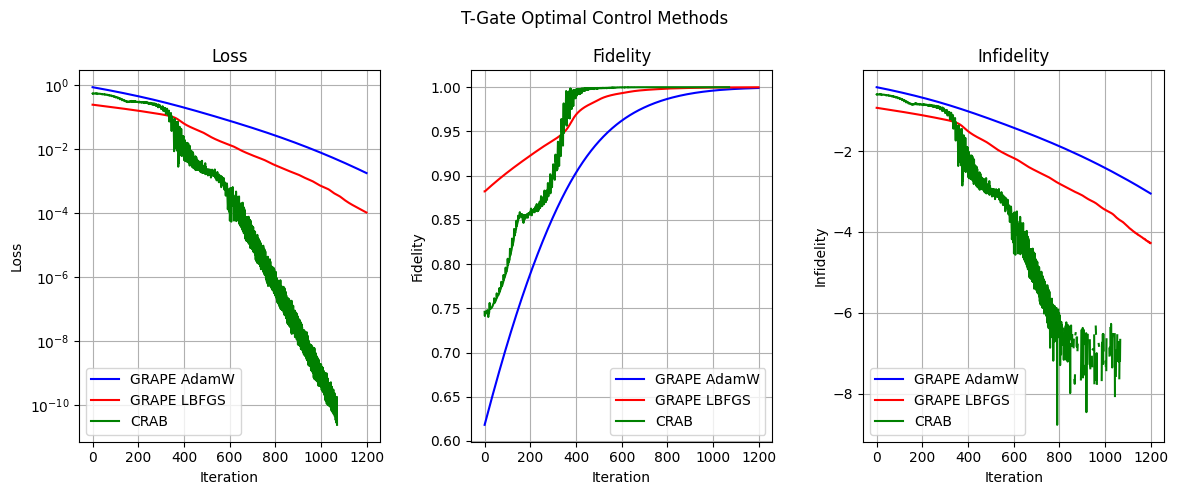

In [20]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle('T-Gate Optimal Control Methods')
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_t, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_t, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_t, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Methods.png')
plt.show()

In [21]:
pd.DataFrame({'loss_grape_t_adam': loss_list_grape_t_adam, 'fid_grape_t_adam': fid_list_grape_t_adam, 'inf_grape_t_adam': inf_list_grape_t_adam}).to_csv('grape_t_adam.csv')
pd.DataFrame({'loss_grape_t_lbfgs': loss_list_grape_t_lbfgs, 'fid_grape_t_lbfgs': fid_list_grape_t_lbfgs, 'inf_grape_t_lbfgs': inf_list_grape_t_lbfgs}).to_csv('grape_t_lbfgs.csv')
pd.DataFrame({'loss_crab_t': loss_list_crab_t, 'fid_crab_t': fid_list_crab_t, 'inf_crab_t': inf_list_crab_t}).to_csv('crab_t.csv')

In [22]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_t_adam = ux_grape_t_adam.detach().cpu().numpy()
uz_grape_t_adam = uz_grape_t_adam.detach().cpu().numpy()
ux_grape_t_lbfgs = ux_grape_t_lbfgs.detach().cpu().numpy()
uz_grape_t_lbfgs = uz_grape_t_lbfgs.detach().cpu().numpy()
x_opt = res.x
ux_grape_t_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_t_crab = [detuning_control(t, x_opt) for t in time_grid]

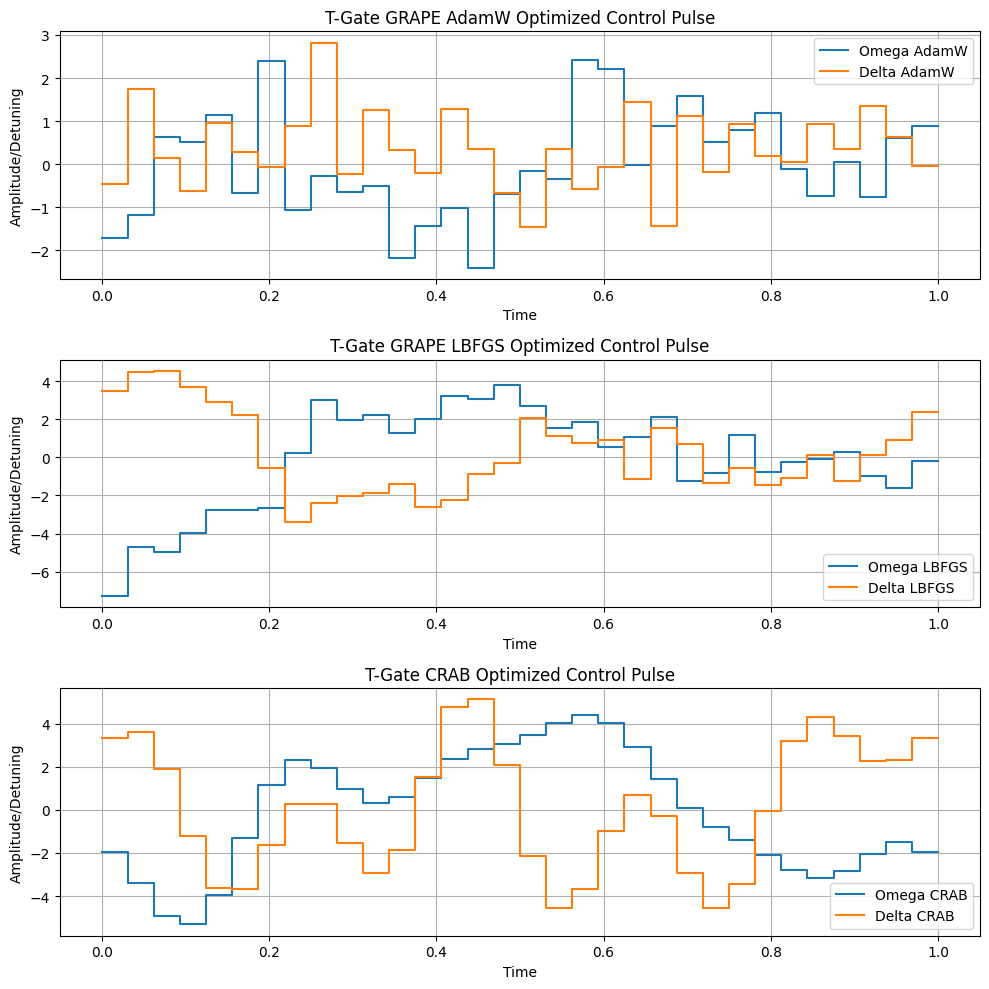

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.step(time_edges, np.append(ux_grape_t_adam, ux_grape_t_adam[-1]), where='post', label='Omega AdamW')
plt.step(time_edges, np.append(uz_grape_t_adam, uz_grape_t_adam[-1]), where='post', label='Delta AdamW')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.step(time_edges, np.append(ux_grape_t_lbfgs, ux_grape_t_lbfgs[-1]), where='post', label='Omega LBFGS')
plt.step(time_edges, np.append(uz_grape_t_lbfgs, uz_grape_t_lbfgs[-1]), where='post', label='Delta LBFGS')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)
plt.step(time_edges, np.append(ux_grape_t_crab, ux_grape_t_crab[-1]), where='post', label='Omega CRAB')
plt.step(time_edges, np.append(uz_grape_t_crab, uz_grape_t_crab[-1]), where='post', label='Delta CRAB')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Pulses.png')
plt.show()

In [24]:
u1x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_adam, 'u1z': u1z_grape_cnot_adam, 'u2x': u2x_grape_cnot_adam, 'u2z': u2z_grape_cnot_adam, 'jzx': jzx_grape_cnot_adam}
optimizer = AdamW([u1x_grape_cnot_adam, u1z_grape_cnot_adam, u2x_grape_cnot_adam, u2z_grape_cnot_adam, jzx_grape_cnot_adam], lr=0.001, weight_decay=0.001)

In [25]:
num_iters = 3000
loss_list_grape_cnot_adam, fid_list_grape_cnot_adam, inf_list_grape_cnot_adam = train_grape(num_iters, optimizer, params, CNOT_target)

Iteration 0: Loss = 4.138025760650635
Fidelity = 0.2330445945262909, Infidelity = -0.11522990465164185
Iteration 100: Loss = 3.9554290771484375
Fidelity = 0.25560227036476135, Infidelity = -0.12819494307041168
Iteration 200: Loss = 3.046891212463379
Fidelity = 0.3833324611186981, Infidelity = -0.20994892716407776
Iteration 300: Loss = 1.8423022031784058
Fidelity = 0.5924569964408875, Infidelity = -0.38982656598091125
Iteration 400: Loss = 0.9952620267868042
Fidelity = 0.7666616439819336, Infidelity = -0.6320138573646545
Iteration 500: Loss = 0.49236956238746643
Fidelity = 0.8806954026222229, Infidelity = -0.9233428239822388
Iteration 600: Loss = 0.22444552183151245
Fidelity = 0.9446759223937988, Infidelity = -1.2570858001708984
Iteration 700: Loss = 0.0946527048945427
Fidelity = 0.9764770865440369, Infidelity = -1.6285089254379272
Iteration 800: Loss = 0.03708447888493538
Fidelity = 0.9907505512237549, Infidelity = -2.033884048461914
Iteration 900: Loss = 0.01356519665569067
Fidelity =

In [42]:
u1x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_lbfgs, 'u1z': u1z_grape_cnot_lbfgs, 'u2x': u2x_grape_cnot_lbfgs, 'u2z': u2z_grape_cnot_lbfgs, 'jzx': jzx_grape_cnot_lbfgs}

loss_list_cnot_grape_lbfgs, fid_list_cnot_grape_lbfgs, inf_list_cnot_grape_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, CNOT_target)
  loss = loss_fn_grape(U, CNOT_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, CNOT_target)
  loss_list_cnot_grape_lbfgs.append(loss.item())
  fid_list_cnot_grape_lbfgs.append(fid)
  inf_list_cnot_grape_lbfgs.append(inf)
  return loss

optimizer = LBFGS([u1x_grape_cnot_lbfgs, u1z_grape_cnot_lbfgs, u2x_grape_cnot_lbfgs, u2z_grape_cnot_lbfgs, jzx_grape_cnot_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_cnot_grape_lbfgs[-1]}, Infidelity: {inf_list_cnot_grape_lbfgs[-1]}")

Iteration 0, Loss: 4.038412094116211
Fidelity: 0.2459987848997116, Infidelity: -0.12262796610593796
Iteration 10, Loss: 3.9615795612335205
Fidelity: 0.2557114362716675, Infidelity: -0.12825866043567657
Iteration 20, Loss: 3.8833296298980713
Fidelity: 0.26570776104927063, Infidelity: -0.1341310441493988
Iteration 30, Loss: 3.804380178451538
Fidelity: 0.27598708868026733, Infidelity: -0.1402536928653717
Iteration 40, Loss: 3.7247912883758545
Fidelity: 0.2865462899208069, Infidelity: -0.14663420617580414
Iteration 50, Loss: 3.644625663757324
Fidelity: 0.29738128185272217, Infidelity: -0.15328028798103333
Iteration 60, Loss: 3.5639660358428955
Fidelity: 0.3084850609302521, Infidelity: -0.1601984202861786
Iteration 70, Loss: 3.482893705368042
Fidelity: 0.3198498785495758, Infidelity: -0.1673952043056488
Iteration 80, Loss: 3.4014997482299805
Fidelity: 0.33146458864212036, Infidelity: -0.17487558722496033
Iteration 90, Loss: 3.319884777069092
Fidelity: 0.3433181345462799, Infidelity: -0.1826

In [34]:
num_channels = 5   # drive, detuning, coupling.
N_params = num_channels * (2 * K)

loss_list_crab_cnot, fid_list_crab_cnot, inf_list_crab_cnot = [], [], []

# Function to construct a control pulse at time t given Fourier coefficients.
def control_pulse(t, coeffs):
    # coeffs is a vector of length 2*K.
    val = 0.0
    for k in range(1, K+1):
        alpha = coeffs[k-1]
        beta  = coeffs[K + k - 1]
        val += alpha * np.cos(k * omega0 * t) + beta * np.sin(k * omega0 * t)
    return val

# Full Hamiltonian at time t, given control parameters x.
def H_total(t, x):
    # Channel 1: drive1 (first 2*K coefficients)
    # Channel 2: detuning1 (next 2*K)
    # Channel 3: drive2 (next 2*K)
    # Channel 4: detuning2 (next 2*K)
    # Channel 5: coupling (last 2*K)
    coeff_drive1    = x[0:2*K]
    coeff_detuning1 = x[2*K:4*K]
    coeff_drive2    = x[4*K:6*K]
    coeff_detuning2 = x[6*K:8*K]
    coeff_coupling  = x[8*K:10*K]

    eps_drive1    = control_pulse(t, coeff_drive1)
    eps_detuning1 = control_pulse(t, coeff_detuning1)
    eps_drive2    = control_pulse(t, coeff_drive2)
    eps_detuning2 = control_pulse(t, coeff_detuning2)
    eps_coupling  = control_pulse(t, coeff_coupling)

    H = (eps_drive1 * sx1 +
         eps_detuning1 * sz1 +
         eps_drive2 * sx2+
         eps_detuning2 * sz2 +
         eps_coupling * szx)
    return H

def propagate_crab(x):
    U = np.eye(4, dtype=complex)
    for t in time_grid:
        H = H_total(t, x)
        U_step = expm(-1j * H * dt)
        U = U_step @ U
    return U

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(CNOT_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = CNOT_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_cnot.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, CNOT_target.numpy())
    fid_list_crab_cnot.append(fid)
    inf_list_crab_cnot.append(inf)
    return loss

x0 = np.random.randn(N_params)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 10000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_17073/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9592
         Function evaluations: 11204


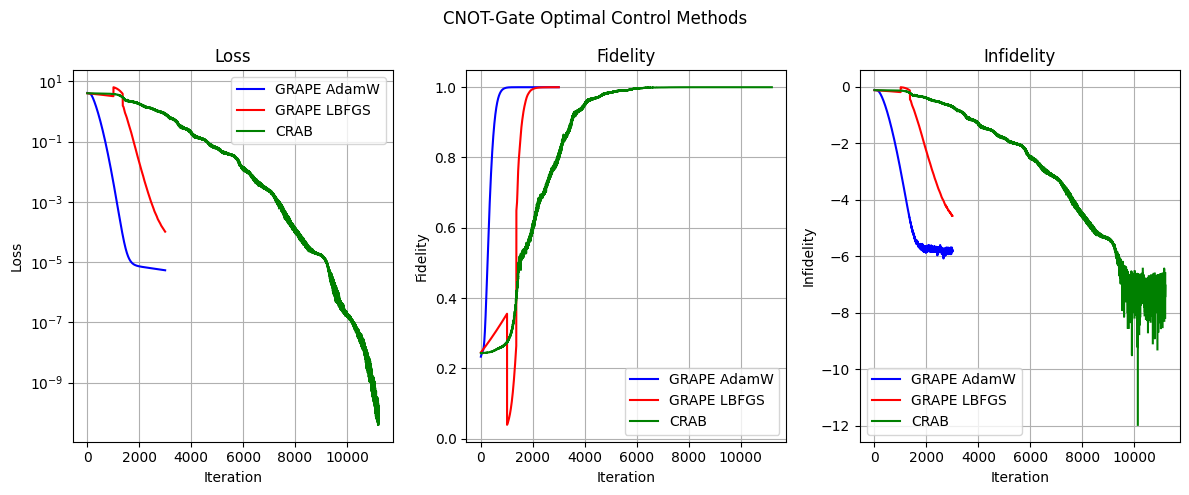

In [43]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle('CNOT-Gate Optimal Control Methods')
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_cnot, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_cnot, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_cnot, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT-Gate Optimal Control Methods.png')
plt.show()

In [36]:
pd.DataFrame({'loss_grape_cnot_adam': loss_list_grape_cnot_adam, 'fid_grape_cnot_adam': fid_list_grape_cnot_adam, 'inf_grape_cnot_adam': inf_list_grape_cnot_adam}).to_csv('grape_cnot_adam.csv')
pd.DataFrame({'loss_grape_cnot_lbfgs': loss_list_cnot_grape_lbfgs, 'fid_grape_cnot_lbfgs': fid_list_cnot_grape_lbfgs, 'inf_grape_cnot_lbfgs': inf_list_cnot_grape_lbfgs}).to_csv('grape_cnot_lbfgs.csv')
pd.DataFrame({'loss_crab_cnot': loss_list_crab_cnot, 'fid_crab_cnot': fid_list_crab_cnot, 'inf_crab_cnot': inf_list_crab_cnot}).to_csv('crab_cnot.csv')

In [ ]:
u1x_grape_cnot_adam = u1x_grape_cnot_adam.detach().cpu().numpy()
u1z_grape_cnot_adam = u1z_grape_cnot_adam.detach().cpu().numpy()
u2x_grape_cnot_adam = u2x_grape_cnot_adam.detach().cpu().numpy()
u2z_grape_cnot_adam = u2z_grape_cnot_adam.detach().cpu().numpy()
coup_str_adam = jzx_grape_cnot_adam.detach().cpu().numpy()



AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [44]:
u1x_grape_cnot_lbfgs = u1x_grape_cnot_lbfgs.detach().cpu().numpy()
u1z_grape_cnot_lbfgs = u1z_grape_cnot_lbfgs.detach().cpu().numpy()
u2x_grape_cnot_lbfgs = u2x_grape_cnot_lbfgs.detach().cpu().numpy()
u2z_grape_cnot_lbfgs = u2z_grape_cnot_lbfgs.detach().cpu().numpy()
coup_str_lbfgs = jzx_grape_cnot_lbfgs.detach().cpu().numpy()

In [45]:
coeff_drive1_opt    = res.x[0:2*K]
coeff_detuning1_opt = res.x[2*K:4*K]
coeff_drive2_opt    = res.x[4*K:6*K]
coeff_detuning2_opt = res.x[6*K:8*K]
coeff_coupling_opt = res.x[8*K:10*K]
time_edges = np.linspace(0, T_total, N+1)
u1x_crab_cnot = np.array([control_pulse(t, coeff_drive1_opt) for t in time_grid])
u1z_crab_cnot = np.array([control_pulse(t, coeff_detuning1_opt) for t in time_grid])
u2x_crab_cnot = np.array([control_pulse(t, coeff_drive2_opt) for t in time_grid])
u2z_crab_cnot = np.array([control_pulse(t, coeff_detuning2_opt) for t in time_grid])
coup_str_crab = np.array([control_pulse(t, coeff_coupling_opt) for t in time_grid])

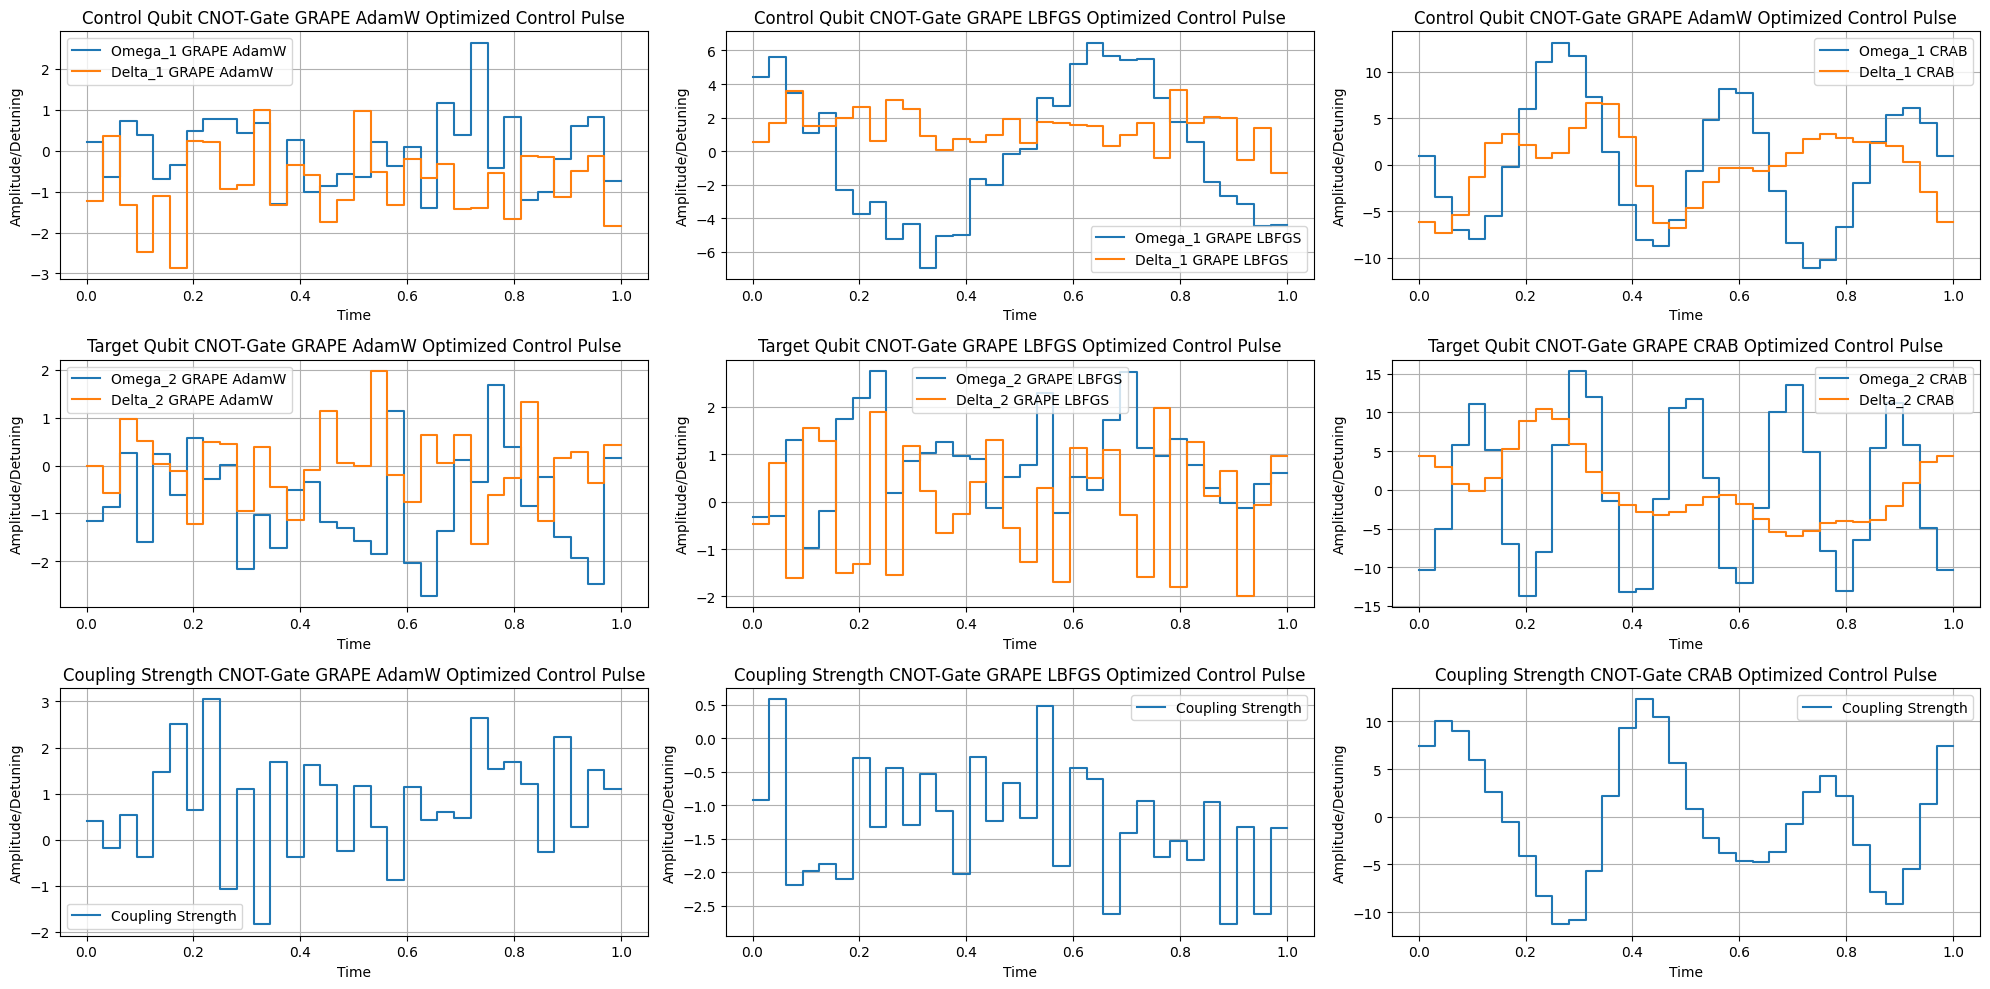

In [46]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 3, 1)
plt.step(time_edges, np.append(u1x_grape_cnot_adam, u1x_grape_cnot_adam[-1]), where='post', label="Omega_1 GRAPE AdamW")
plt.step(time_edges, np.append(u1z_grape_cnot_adam, u1z_grape_cnot_adam[-1]), where='post', label="Delta_1 GRAPE AdamW")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 2)
plt.step(time_edges, np.append(u1x_grape_cnot_lbfgs, u1x_grape_cnot_lbfgs[-1]), where='post', label="Omega_1 GRAPE LBFGS")
plt.step(time_edges, np.append(u1z_grape_cnot_lbfgs, u1z_grape_cnot_lbfgs[-1]), where='post', label="Delta_1 GRAPE LBFGS")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 3)
plt.step(time_edges, np.append(u1x_crab_cnot, u1x_crab_cnot[-1]), where='post', label="Omega_1 CRAB")
plt.step(time_edges, np.append(u1z_crab_cnot, u1z_crab_cnot[-1]), where='post', label="Delta_1 CRAB")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 4)
plt.step(time_edges, np.append(u2x_grape_cnot_adam, u2x_grape_cnot_adam[-1]), where='post', label="Omega_2 GRAPE AdamW")
plt.step(time_edges, np.append(u2z_grape_cnot_adam, u2z_grape_cnot_adam[-1]), where='post', label="Delta_2 GRAPE AdamW")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 5)
plt.step(time_edges, np.append(u2x_grape_cnot_lbfgs, u2x_grape_cnot_lbfgs[-1]), where='post', label="Omega_2 GRAPE LBFGS")
plt.step(time_edges, np.append(u2z_grape_cnot_lbfgs, u2z_grape_cnot_lbfgs[-1]), where='post', label="Delta_2 GRAPE LBFGS")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 6)
plt.step(time_edges, np.append(u2x_crab_cnot, u2x_crab_cnot[-1]), where='post', label="Omega_2 CRAB")
plt.step(time_edges, np.append(u2z_crab_cnot, u2z_crab_cnot[-1]), where='post', label="Delta_2 CRAB")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 7)
plt.step(time_edges, np.append(coup_str_adam, coup_str_adam[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 8)
plt.step(time_edges, np.append(coup_str_lbfgs, coup_str_lbfgs[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 9)
plt.step(time_edges, np.append(coup_str_crab, coup_str_crab[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT_Gate_Optimal_Control_Pulses.png')
plt.show()